# Ensemble Learning: Boosting and Stacking

## Boosting (Gradient Boosting)

In [1]:
# Importing necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as kh
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingRegressor, StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Loading, Defining and Understanding the Dataset

In [3]:
path = kh.dataset_download("anubhavgoyal10/laptop-prices-dataset")
df = pd.read_csv(f'{path}/laptopPrice.csv')

In [4]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              823 non-null    object
 1   processor_brand    823 non-null    object
 2   processor_name     823 non-null    object
 3   processor_gnrtn    823 non-null    object
 4   ram_gb             823 non-null    object
 5   ram_type           823 non-null    object
 6   ssd                823 non-null    object
 7   hdd                823 non-null    object
 8   os                 823 non-null    object
 9   os_bit             823 non-null    object
 10  graphic_card_gb    823 non-null    object
 11  weight             823 non-null    object
 12  warranty           823 non-null    object
 13  Touchscreen        823 non-null    object
 14  msoffice           823 non-null    object
 15  Price              823 non-null    int64 
 16  rating             823 non-null    object
 1

In [6]:
df.describe()

,Price,Number of Ratings,Number of Reviews
count,823.000000,823.000000,823.000000
mean,76745.177400,315.301337,37.609964
std,45101.790525,1047.382654,121.728017
min,16990.000000,0.000000,0.000000
25%,46095.000000,0.000000,0.000000
50%,64990.000000,17.000000,2.000000
75%,89636.000000,139.500000,18.000000
max,441990.000000,15279.000000,1947.000000


### Visualization

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Number of Ratings'}>],
       [<Axes: title={'center': 'Number of Reviews'}>, <Axes: >]],
      dtype=object)

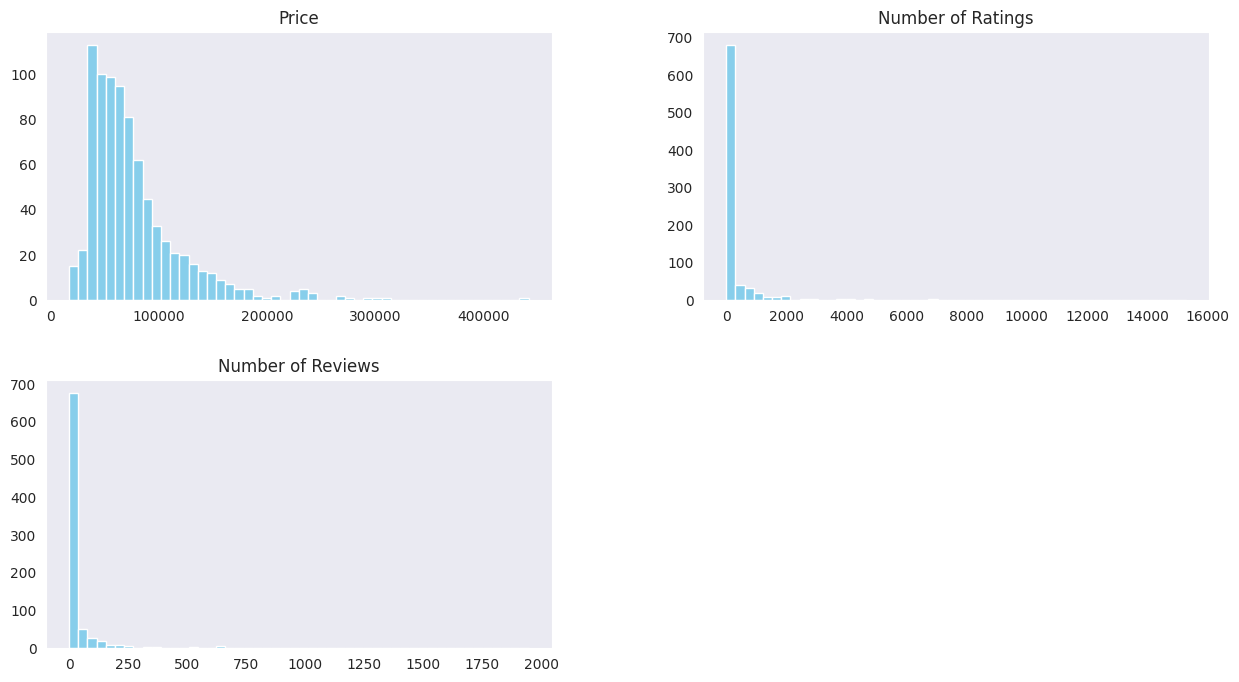

In [7]:
# Historgram
df.select_dtypes(include=[np.number]).hist(figsize=(15,8), bins=50, grid=False, color='skyblue')

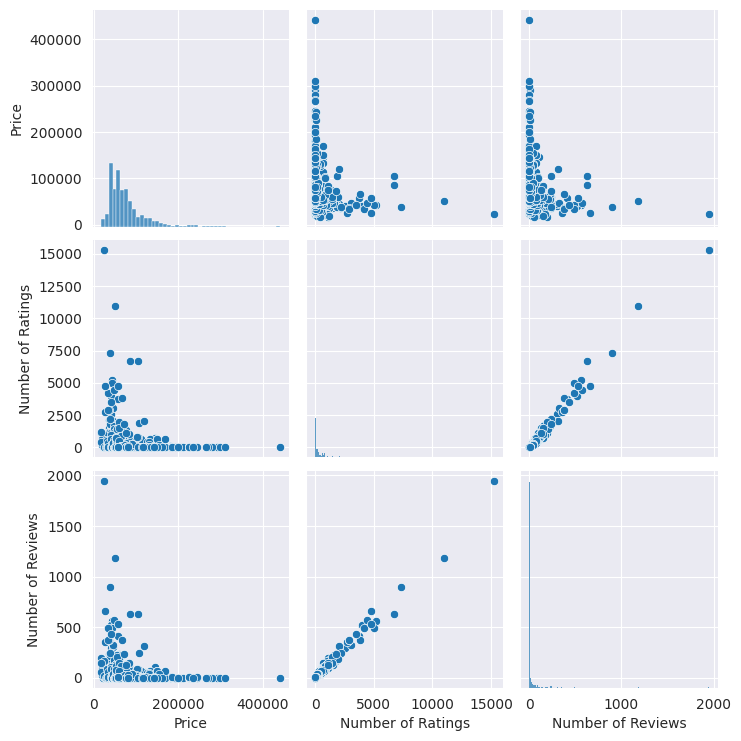

In [8]:
# Pairplot
sns.pairplot(df)

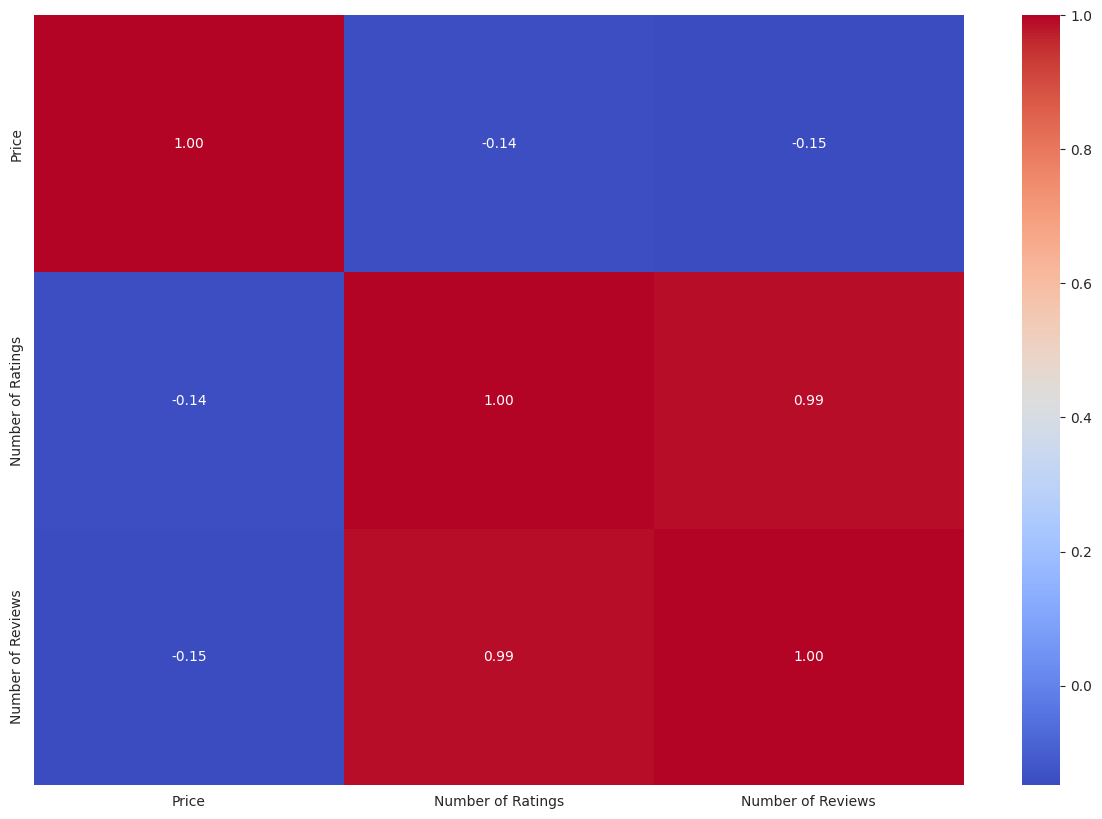

In [9]:
# Correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Preprocessing

In [10]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=[object]).columns

In [12]:
# Encode the categorical columns with pandas dummies
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [13]:
# Convert boolean columns to int64
df = df.astype({col: 'int64' for col in df.select_dtypes(include=['bool']).columns})

In [14]:
# Standardize the numerical columns
stc = StandardScaler()

df[num_cols] = stc.fit_transform(df[num_cols])

In [15]:
# Split the data
X = df.drop('Price', axis=1)
y = df['Price']

### Training and Evaluating the Model

In [16]:
 # Splitting data to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
gbrt = GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=2, learning_rate=0.1)

gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=42)

In [18]:
y_pred = gbrt.predict(X_test)

In [19]:
# Evaluating the model
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.22708146458030992
RMSE: 0.4765306543972905
R2: 0.7632595768324549


### Hyperparameter Tuning: Randomized Search

In [20]:
# Define the parameter grid
param_grid = {
    'n_estimators': np.arange(100, 1000, 50),
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'max_depth': np.arange(1, 5, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'n_iter_no_change': [5, 7, 10],
}

In [21]:
# Initialize the GradientBoostingRegressor
gbrt = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbrt,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

In [22]:
# Fit the random search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.15, 0.2, 0.3],
                                        'max_depth': array([1, 2, 3, 4]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950]),
                                        'n_iter_no_change': [5, 7, 10]},
                   random_state=42, scoring='r2')

In [23]:
# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best R2 Score: {best_score}')

Best Parameters: {'n_iter_no_change': 5, 'n_estimators': np.int64(850), 'min_samples_split': np.int64(7), 'min_samples_leaf': np.int64(10), 'max_depth': np.int64(3), 'learning_rate': 0.2}
Best R2 Score: 0.702364899082522


In [24]:
# Initialize the model with the best parameters
best_gbrt = random_search.best_estimator_
best_gbrt.fit(X_train, y_train)

# Predict the target variable
y_pred_best = best_gbrt.predict(X_test)

In [25]:
# Evaluate the model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best RMSE: {rmse_best}")
print(f"Best MSE: {mse_best}")
print(f"Best R2: {r2_best}")

Best RMSE: 0.5567333969658126
Best MSE: 0.309952075297093
Best R2: 0.6768640469925207


## Stacking Classifier

In [26]:
path = kh.dataset_download("mujtabamatin/air-quality-and-pollution-assessment")
df = pd.read_csv(f'{path}/updated_pollution_dataset.csv')

In [27]:
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


### Preprocessing

In [28]:
# Split the data
X = df.drop('Air Quality', axis=1)
y = df['Air Quality']

In [29]:
# Standardize the X columns
stc = StandardScaler()

X = stc.fit_transform(X)

In [30]:
# Encode the y columns with pandas dummies
y = pd.get_dummies(y)

In [31]:
y = y.astype({col: 'int64' for col in y.select_dtypes(include=['bool']).columns})

In [37]:
y = y.idxmax(axis=1)

In [38]:
X.shape, y.shape

((5000, 9), (5000,))

In [40]:
y

0        Moderate
1        Moderate
2        Moderate
3            Good
4            Good
          ...    
4995    Hazardous
4996     Moderate
4997     Moderate
4998         Good
4999     Moderate
Length: 5000, dtype: object

### Training and Evaluating the Model

In [41]:
# Split the data to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# LogisticRegression
log_reg = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, C=0.1)
log_reg.fit(X_train, y_train)

# Predicting the model
y_pred_log_leg = log_reg.predict(X_test)

# Evaluating the model
acc_log_leg = accuracy_score(y_test, y_pred_log_leg)
class_log_leg = classification_report(y_test, y_pred_log_leg)

print(f'Log Reg: {acc_log_leg}')
print(class_log_leg)

Log Reg: 0.939
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.91      0.78      0.84       111
    Moderate       0.95      0.96      0.95       294
        Poor       0.82      0.87      0.85       186

    accuracy                           0.94      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.94      0.94      0.94      1000



In [47]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5, n_jobs=-1)
rfc.fit(X_train, y_train)

# Predicting the model
y_pred_rfc = rfc.predict(X_test)

# Evaluating the model
acc_rfc = accuracy_score(y_test, y_pred_rfc)
class_rfc = classification_report(y_test, y_pred_rfc)

print(f'RFC: {acc_rfc}')
print(class_rfc)

RFC: 0.939
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.93      0.77      0.85       111
    Moderate       0.95      0.95      0.95       294
        Poor       0.81      0.89      0.85       186

    accuracy                           0.94      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.94      0.94      0.94      1000



In [48]:
# SVC
svc = SVC(random_state=42, C=0.1, kernel='linear')
svc.fit(X_train, y_train)

# Predicting the model
y_pred_svc = svc.predict(X_test)

# Evaluating the model
acc_svc = accuracy_score(y_test, y_pred_svc)
class_svc = classification_report(y_test, y_pred_svc)

print(f'SVC: {acc_svc}')
print(class_svc)

SVC: 0.946
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.92      0.81      0.86       111
    Moderate       0.96      0.96      0.96       294
        Poor       0.84      0.89      0.86       186

    accuracy                           0.95      1000
   macro avg       0.93      0.91      0.92      1000
weighted avg       0.95      0.95      0.95      1000



In [49]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=SVC(random_state=43),
    cv=5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=SVC(random_state=43))

In [50]:
# Predicting the model
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluating the model
acc_stacking = accuracy_score(y_test, y_pred_stacking)
class_stacking = classification_report(y_test, y_pred_stacking)

print(f'Stacking: {acc_stacking}')
print(class_stacking)

Stacking: 0.962
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.92      0.87      0.90       111
    Moderate       0.98      0.97      0.97       294
        Poor       0.88      0.92      0.90       186

    accuracy                           0.96      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.96      0.96      0.96      1000



### Comparison of Model Accuracies: Visualization

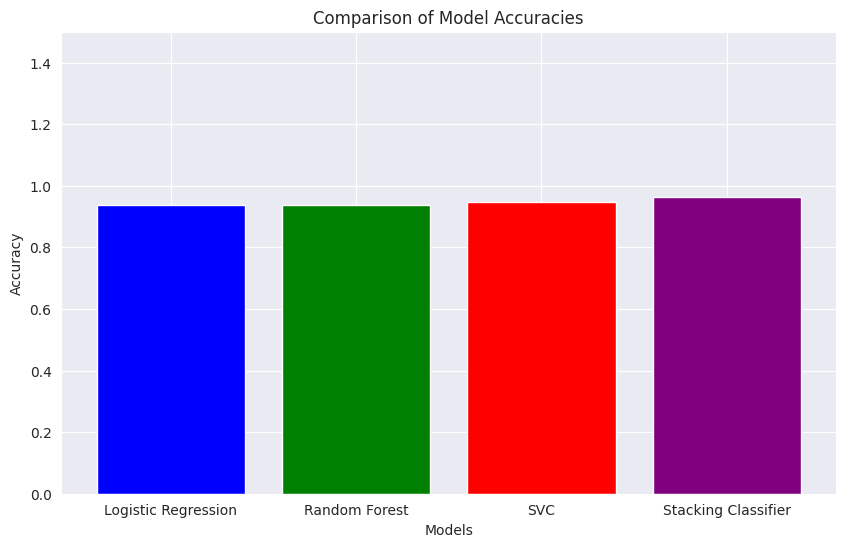

In [52]:
# Accuracy scores of the models
model_names = ['Logistic Regression', 'Random Forest', 'SVC', 'Stacking Classifier']
accuracies = [acc_log_leg, acc_rfc, acc_svc, acc_stacking]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1.5)  # Set y-axis limits from 0 to 1
plt.show()

I put SVC as the final estimator because it has the highest accuracy score. And because of that the stacking classifier has the highest accuracy score.